# Exploring Stock Data Python
##### DAT 301 Final Project
##### Lucas Gibson
##### 2/20/2022


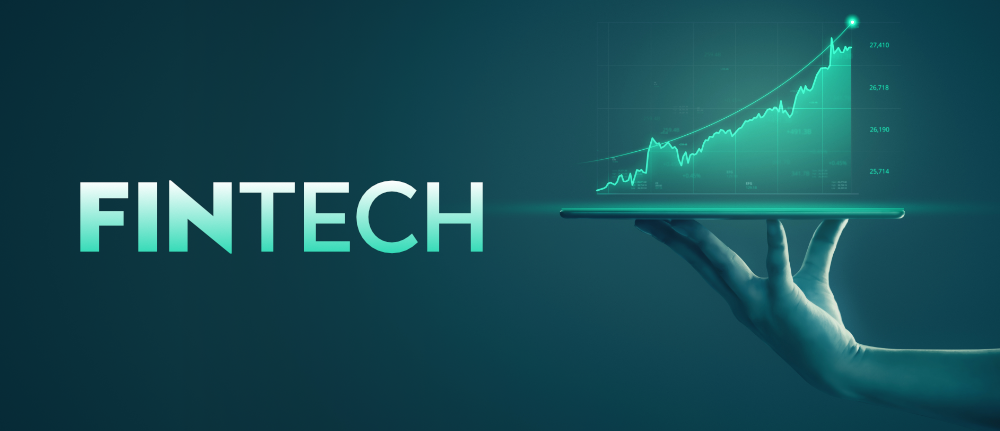

This project is a continuation of my midterm project which explored various aspects of fintech utilizing R. My project consists of plot data from the SPY, FAANG stocks, and Bitcoin. The S&P is largely considered the financial barometer of the market and a baseline investors use for returns. 

**The purpose of this project is to compare baseline returns of the S&P to other symbols and techincal analysis stratedgies.** 

Some of the comments I received in order to improve my last project was to add more historical data to get a more accurate result. In addition, I changed the strategy from a price crossover to 2 different moving averages to trigger a buy. The strategy is also applied to Bitcoin.

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import norm
import talib as ta
import mplfinance as mpl
import plotly.express as px
import plotly.graph_objs as go
import random
import datetime as dt

In [2]:
# initializing Parameters
tickers = ["FB", "AMZN", "AAPL", "NFLX", "GOOG"]

# Getting the the longer SPY data along with FAANG
data = wb.DataReader('SPY', data_source='yahoo', start='1995-1-1')
fang = wb.DataReader(tickers, data_source='yahoo', start='2008-1-1')

start = dt.datetime(2018,1,1)
end = dt.datetime.now()

btc = wb.DataReader('BTC-USD', 'yahoo', start, end)

#Create another variable for SPY data with a shorter time period so candle
#stick chart is more legible.
spy = wb.DataReader('SPY', data_source='yahoo', start='2018-1-1')

#Get a list of of SPY stocks from 
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]
df = first_table

randSymbols = df['Symbol'].values.tolist()

#Create a random list of 5 symbols
n = 5
rtickers = []
for i in range(n):
    rtickers.append(random.choice(randSymbols))
    
#Get data for the randomly chosen     
randomTickers = wb.DataReader(rtickers, data_source='yahoo', start='2008-1-1')




#Add SMA to data, used later in SMA strat
data["SPY100MA"] = data['Close'].rolling(100).mean()
data["SPY200MA"] = data['Close'].rolling(200).mean()

btc["BTC50MA"] = btc['Close'].rolling(50).mean()
btc["BTC100MA"] = btc['Close'].rolling(100).mean()

spy["SPY50MA"] = spy['Close'].rolling(50).mean()
spy["SPY100MA"] = spy['Close'].rolling(100).mean()

### SPY Data Plotted Using Candlesticks And Moving Averages (4 years)

**100 and 200 day MA's ploted.**
This is simply to show the user what Japanese Candelsticks and MA's look like


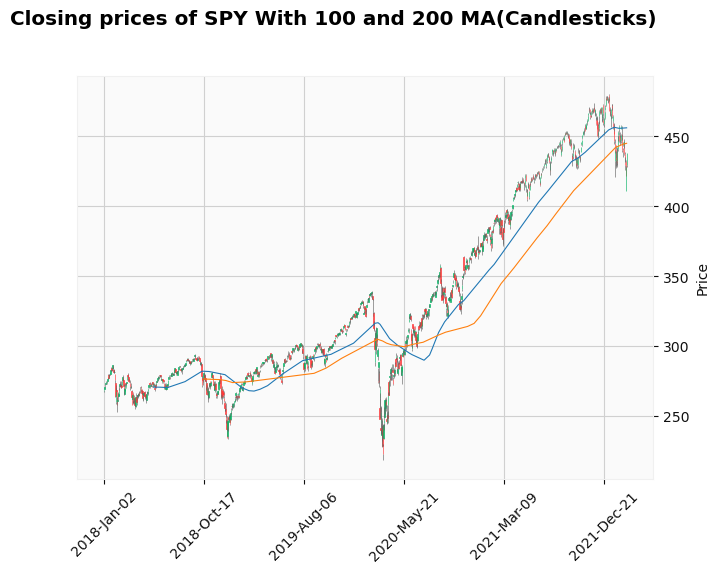

In [3]:
# Display S&P Candlestick Chart
mpl.plot(spy,type="candle", mav =(100,200),
         title = "Closing prices of SPY With 100 and 200 MA(Candlesticks)",  
         style="yahoo", warn_too_much_data=5000
    )

In [4]:
#Calculations for Yearly returns for SPY and FANG Symbols
spy_yearly_returns = data['Adj Close'].resample('Y').ffill().pct_change()
fang_yearly_returns = fang['Adj Close'].resample('Y').ffill().pct_change()
randomTickers_returns = randomTickers['Adj Close'].resample('Y').ffill().pct_change()

fangReturns = (fang_yearly_returns + 1).cumprod()
fangReturns = fangReturns.iloc[-1]

spyReturns = (spy_yearly_returns + 1).cumprod()
spyReturns = spyReturns.tail(1)

RandTickerReturns = (randomTickers_returns + 1).cumprod()
RandTickerReturns = RandTickerReturns.iloc[-1]


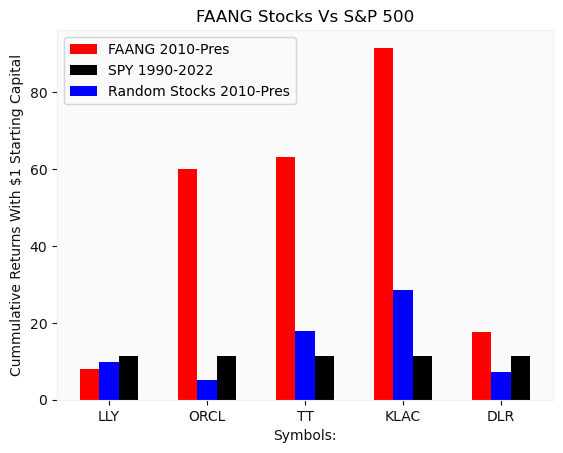

In [5]:
#Plot 3 different bars for each symbol
X_axis = np.arange(len(tickers))
plt.bar(X_axis - 0.2, fangReturns, 0.2, label = 'FAANG 2010-Pres',color= 'red')
plt.bar(X_axis + 0.2, spyReturns, 0.2, label = 'SPY 1990-2022',  color='black')
plt.bar(X_axis, RandTickerReturns,.2, color=  'blue', label = 'Random Stocks 2010-Pres' )

plt.xticks(X_axis, rtickers)
plt.xlabel("Symbols:")
plt.ylabel("Cummulative Returns With $1 Starting Capital")
plt.title("FAANG Stocks Vs S&P 500")
plt.grid(False)
plt.legend()
plt.show()


### Line Chart Of Just FAANG vs SPY

**Line Chart of 25 years of SPY returns versus the publicly traded inception of FAANG companies**

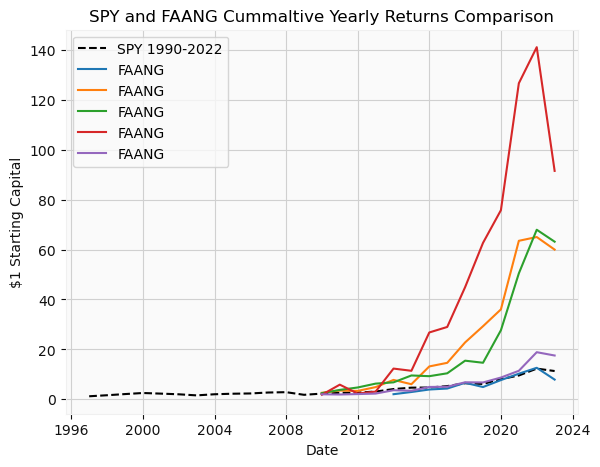

In [6]:
#Plot Fang Stock Monthly Returns
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
spy_cum_returns = (spy_yearly_returns + 1).cumprod()
fang_cum_returns = (fang_yearly_returns + 1).cumprod()
ax1.plot(spy_cum_returns, linestyle='dashed', color= 'black',label = 'SPY 1990-2022')
ax1.plot(fang_cum_returns, label = 'FAANG')
ax1.set_xlabel("Date")
ax1.set_ylabel("$1 Starting Capital")
ax1.set_title("SPY and FAANG Cummaltive Yearly Returns Comparison")
plt.legend()
plt.show()

### Monte Carlo Simulation Of SPY

###### The Monte Carlo Simulation is used to estimate multiple outcomes of SPY returns. I was unable to exactly re-create my random coin flip stategy in Python but the Monte Carlo method was very similar and much cleaner.

###### The majority of outcomes form a standard deviation with a potential upward skew. There are also both extreme positive and negative outliers, similar to that of a black swan event.

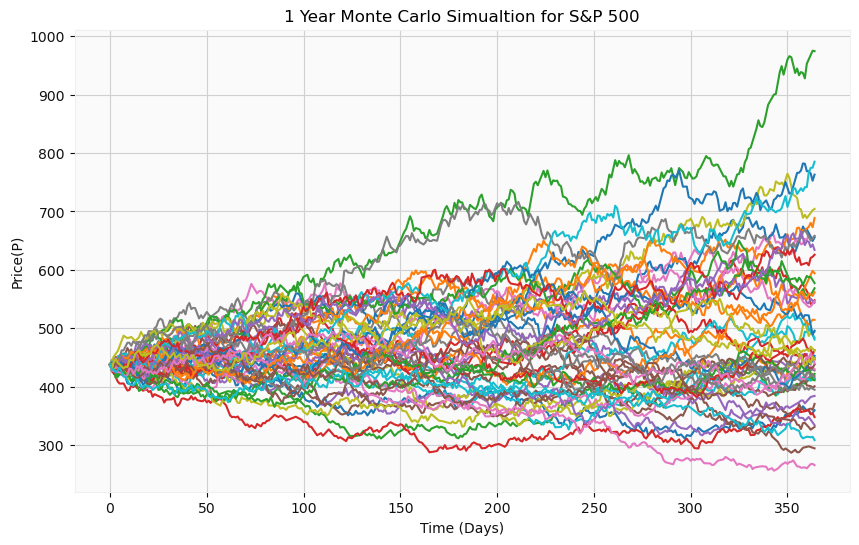

In [7]:
def get_simulation(ticker, name):
  data = pd.DataFrame()
  data = wb.DataReader(ticker, data_source='yahoo', start='1995-1-1')['Adj Close']
  
  
  
  log_returns = np.log(1 + data.pct_change())
  u = log_returns.mean()
  var = log_returns.var()
  
  drift = u - (.5 * var)
  
  stdev = log_returns.std()
  
  days = 365
  iterations = 50
  z = norm.ppf(np.random.rand(days,iterations))
  
  daily_returns = np.exp(drift + stdev * z)
  
  S0 = data.iloc[-1]
  
  price_list = np.zeros_like(daily_returns)
  price_list[0]= S0
  for t in range(1, days):
    price_list[t] = price_list[t - 1] * daily_returns[t]
    
  plt.figure(figsize=(10,6))
  plt.title("1 Year Monte Carlo Simualtion for " + name)
  plt.ylabel("Price(P)")
  plt.xlabel("Time (Days)")
  plt.plot(price_list)
  plt.show()
    
get_simulation("SPY", "S&P 500" )

### Techinical Analysis Strategy- Simple Moving Average Crossover

###### I revamped my strategy from my R code. This strategy works by using 2 simple moving averages. The 1st is the faster one (100 ma) where as the 2nd is a 200ma. When the shorter/more repsonsive of the averages crosses over the longer a buy signal is triggered. The signal is represent  by a column of 1's in the Position column. When the shorter ma is < longer ma a 0 or sell signal is generated. The cummulative returns are then represented in a chart. This is oppossed to price crossing the moving average to generate the buy signal

###### The Buy and Hold Strategy outpreforms that of the Moving Average Strat by such a significant margin that scraping it for another approach may be most beneficial.

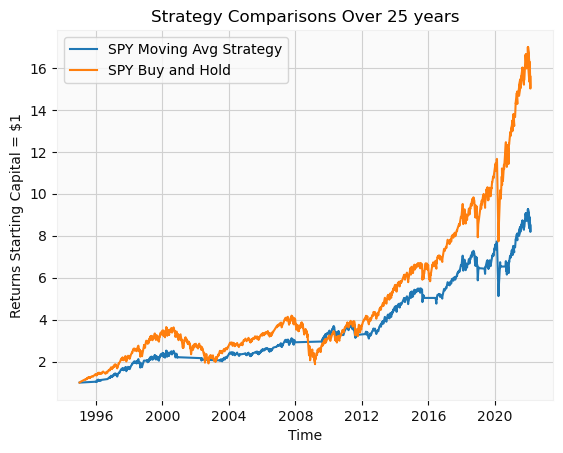

In [8]:
"""
SMA Crossover Strat
This Strategy takes 2 moving averages(100 & 200), when the 100 crosses the 200
moving average a buy signal is triggered. The posistion column will be assigned
a 1 for a buy and a 0 to sell.
"""
#SPY, BTC Moving Average Cross across different timeframes
data["Position"] = np.where(data["SPY100MA"] > data["SPY200MA"], 1,0)
btc["Position"] = np.where(btc["BTC50MA"] > btc["BTC100MA"], 1,0)
spy["Position"] = np.where(spy["SPY50MA"] > spy["SPY100MA"], 1,0)

#The data column is shifted in order to make the trade a day after MA cross
data["Position"].shift();
btc["Position"].shift();
spy["Position"].shift();

#On the days when trades happen create new column with the percentage change for that day
data["StrategyPct"] = data["Adj Close"].pct_change(1) * data['Position']
btc["StrategyPct"] = btc["Adj Close"].pct_change(1) * btc['Position']
spy["StrategyPct"] = spy["Adj Close"].pct_change(1) * spy['Position']

#Calc and create returns column for MA strat
data["Strategy"] = (data["StrategyPct"] + 1).cumprod()
btc["Strategy"] = (btc["StrategyPct"] + 1).cumprod()
spy["Strategy"] = (spy["StrategyPct"] + 1).cumprod()

#Add Buy and Hold Column
data['Buy&Hold'] = (data['Adj Close'].pct_change(1) + 1).cumprod()
spy['Buy&Hold'] = (spy['Adj Close'].pct_change(1) + 1).cumprod()
btc['Buy&Hold'] = (btc['Adj Close'].pct_change(1) + 1).cumprod()


plt.plot(data["Strategy"], label='SPY Moving Avg Strategy')
plt.plot(data["Buy&Hold"],  label="SPY Buy and Hold")
plt.title("Strategy Comparisons Over 25 years")
plt.xlabel("Time")
plt.ylabel("Returns Starting Capital = $1")
plt.legend()
plt.show()

### Moving Average Strategy With BTC

###### This plot is using the same strategy and logic as the one above but includes BTC and a shorter timeframe for SPY so the reader can view it more easily. It is a buy and hold versus the Ma strat of Bitcoin.

###### However, the outcomes were quite different. Bitcoin's return are far and above that of the SPY  but the strategy outpreformed the buy and hold method by a decent margin. 

###### This possibly suggests the strategy is more effective with BTC and BTC is possibly more of a trend following instrument, however this hypothesis needs much further exploration.

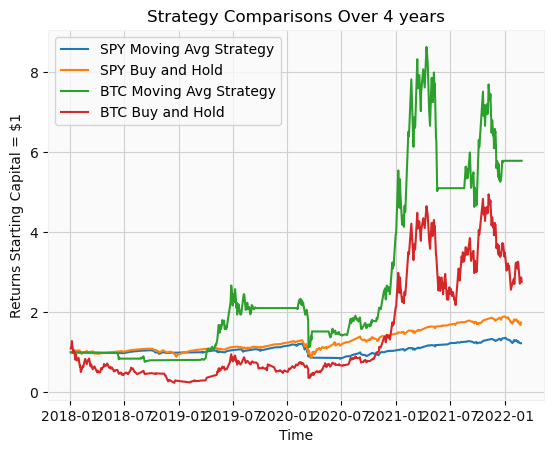

In [9]:
#The timeframe for the SPY was shortened in order to display BTC prices alongside
plt.plot(spy["Strategy"], label='SPY Moving Avg Strategy')
plt.plot(spy["Buy&Hold"],  label="SPY Buy and Hold")
plt.plot(btc["Strategy"], label='BTC Moving Avg Strategy')
plt.plot(btc["Buy&Hold"],  label="BTC Buy and Hold")
plt.title("Strategy Comparisons Over 4 years")
plt.xlabel("Time")
plt.ylabel("Returns Starting Capital = $1")
plt.legend();

## Conclusion:

###### In conclusion I found many similarities and a few diferences between this project and the one done in R. In fact, I believe Python to be a more useful language to invest my time in, at least when it comes to the job market.

###### I was able to analyze more data when it came to the SPY which further confirmed results I had in the mid term project. I was also able to improve the project by integrating BTC into my strategy. Additionally, to my surprise my moving average strategy actually outperformed a simple buy and hold strat in Bitcoin.

###### I believe as I get more experienced with Python I will be able perform more advanced strategies upon the data. Financial markets are something I'm interested in and provide a great way to get my feet wet in Python